In [1]:

import pickle
import time
import logging
import numpy as np
import extra_data as ed
from copy import copy
import os
from scipy import optimize
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from scipy import special

from sklearn.decomposition import PCA

import cv2

import matplotlib.pyplot as plt
from skimage import transform

import matplotlib.style
import matplotlib as mpl
# mpl.style.use('./newClassic.mplstyle')

%config InlineBackend.figure_format='retina'

In [2]:
def extraVISARImages_mean(exp_id, run_id):
    # exp_id = 900352  # Commisioning experiment
    # run_id = 184  # Streak camera calibration image run

    # Import run data and display info on run
    run = ed.open_run(exp_id, run_id)
    # run.info()
    # Determine first and last train ids
    first_train = run.train_ids[0]
    last_train = run.train_ids[-1]
    # print(f"First train ID: {first_train}")
    # print(f"Last train ID: {last_train}")

    # Create a mask for pandas df where no data exists
    mask = (
        run["HED_SYDOR_TEST/CAM/KEPLER_1:daqOutput", "data.image.pixels"].data_counts() != 0
    )

    # Create array for train IDs where data exists
    indexes = mask.to_numpy().nonzero() + first_train
    indexes_count = indexes.shape[1]
    # Total number of trains with data
    # print(f"{indexes_count} Train IDs with data present:\n{indexes}")

    # # Select train ID for streak calibration
    # train_id = 1605832127
    # print(f'\nSelecting Train ID: {train_id}')

    # Raw data from streak camera image
    kep1 = (
        run["HED_SYDOR_TEST/CAM/KEPLER_1:daqOutput"]["data.image.pixels"]
        .select_trains(ed.by_id[np.squeeze(indexes)])
        .ndarray()
    )


    imgKEP1_r = np.mean(kep1[:, :, :], axis = 0)
    # Rotate image 90 degrees
    imgKEP1_r = cv2.rotate(imgKEP1_r, cv2.ROTATE_90_COUNTERCLOCKWISE)
    f = np.loadtxt('../DewarpingCalibrationFiles/VISAR_KEPLER1_20nsWindow_900499_run75_polynomial_16042025.cal', delimiter=',')
    original_grid_Y_evt1 = f[:, 0]
    original_grid_X_evt1 = f[:, 1]

    cartesian_grid_Y_evt1 = f[:, 2]
    cartesian_grid_X_evt1 = f[:, 3]

    user_grid_evt1 = [(i, j) for (i, j) in zip(original_grid_Y_evt1, original_grid_X_evt1)]
    output_grid_evt1 = [(i, j) for (i, j) in zip(cartesian_grid_Y_evt1, cartesian_grid_X_evt1)]


    # load grid coordinates from file
    grid_1, grid_2 = np.mgrid[0:4095:4096j, 0:4095:4096j]
    grid_z = griddata(
        output_grid_evt1, user_grid_evt1, (grid_1, grid_2), method="linear"
    )  # used to visualize the coordinates on image
    map_1 = np.append([], [ar[:, 1] for ar in grid_z]).reshape(4096, 4096)
    map_2 = np.append([], [ar[:, 0] for ar in grid_z]).reshape(4096, 4096)
    map_1_32 = map_1.astype("float32")
    map_2_32 = map_2.astype("float32")
    

    imgKEP1_r_dewarp = cv2.remap(
        imgKEP1_r, map_1_32, map_2_32, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )

    imgKEP1_r_dewarp = np.fliplr(imgKEP1_r_dewarp)
    
    

    mask = (
        run["HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput", "data.image.pixels"].data_counts() != 0
    )

    # Create array for train IDs where data exists
    indexes = mask.to_numpy().nonzero() + first_train
    indexes_count = indexes.shape[1]
    # Total number of trains with data
    # print(f"{indexes_count} Train IDs with data present")


    kep2 = (
        run["HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput"]["data.image.pixels"]
        .select_trains(ed.by_id[np.squeeze(indexes)])
        .ndarray()
    )

    imgKEP2_r = np.mean(kep2, axis = 0)
    imgKEP2_r = cv2.rotate(imgKEP2_r, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    
    # f = np.loadtxt('../../VISAR_CalibrationFiles_latest/VISAR_KEPLER2_20nsWindow_p2740_run26_evt1_V2.cal', delimiter=',')
    # f = np.loadtxt('../VISAR_CalibrationFiles_latest/VISAR_KEPLER2_20nsWindow_p2740_run1222_evt1_polynomial.cal', delimiter=',')
    f = np.loadtxt('../DewarpingCalibrationFiles/VISAR_KEPLER2_20nsWindow_p2740_run1222_evt1_polynomial_AdditionalPointForXrayFiducial.cal', delimiter=',')

    original_grid_Y_evt1 = f[:, 0]
    original_grid_X_evt1 = f[:, 1]

    cartesian_grid_Y_evt1 = f[:, 2]
    cartesian_grid_X_evt1 = f[:, 3]

    user_grid_evt1 = [(i, j) for (i, j) in zip(original_grid_Y_evt1, original_grid_X_evt1)]
    output_grid_evt1 = [(i, j) for (i, j) in zip(cartesian_grid_Y_evt1, cartesian_grid_X_evt1)]


    # load grid coordinates from file
    grid_1, grid_2 = np.mgrid[0:4095:4096j, 0:4095:4096j]
    grid_z = griddata(
        output_grid_evt1, user_grid_evt1, (grid_1, grid_2), method="linear"
    )  # used to visualize the coordinates on image
    map_1 = np.append([], [ar[:, 1] for ar in grid_z]).reshape(4096, 4096)
    map_2 = np.append([], [ar[:, 0] for ar in grid_z]).reshape(4096, 4096)
    map_1_32 = map_1.astype("float32")
    map_2_32 = map_2.astype("float32")
    

    imgKEP2_r_dewarp = cv2.remap(
        imgKEP2_r, map_1_32, map_2_32, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )
    
    imgKEP2_r_dewarp = np.fliplr(imgKEP2_r_dewarp)
    
    return imgKEP1_r_dewarp, imgKEP2_r_dewarp

In [3]:
proposalNumber = 7902
runNumber = 23

In [4]:
imgKEP1_r, imgKEP2_r  = extraVISARImages_mean(proposalNumber, runNumber)

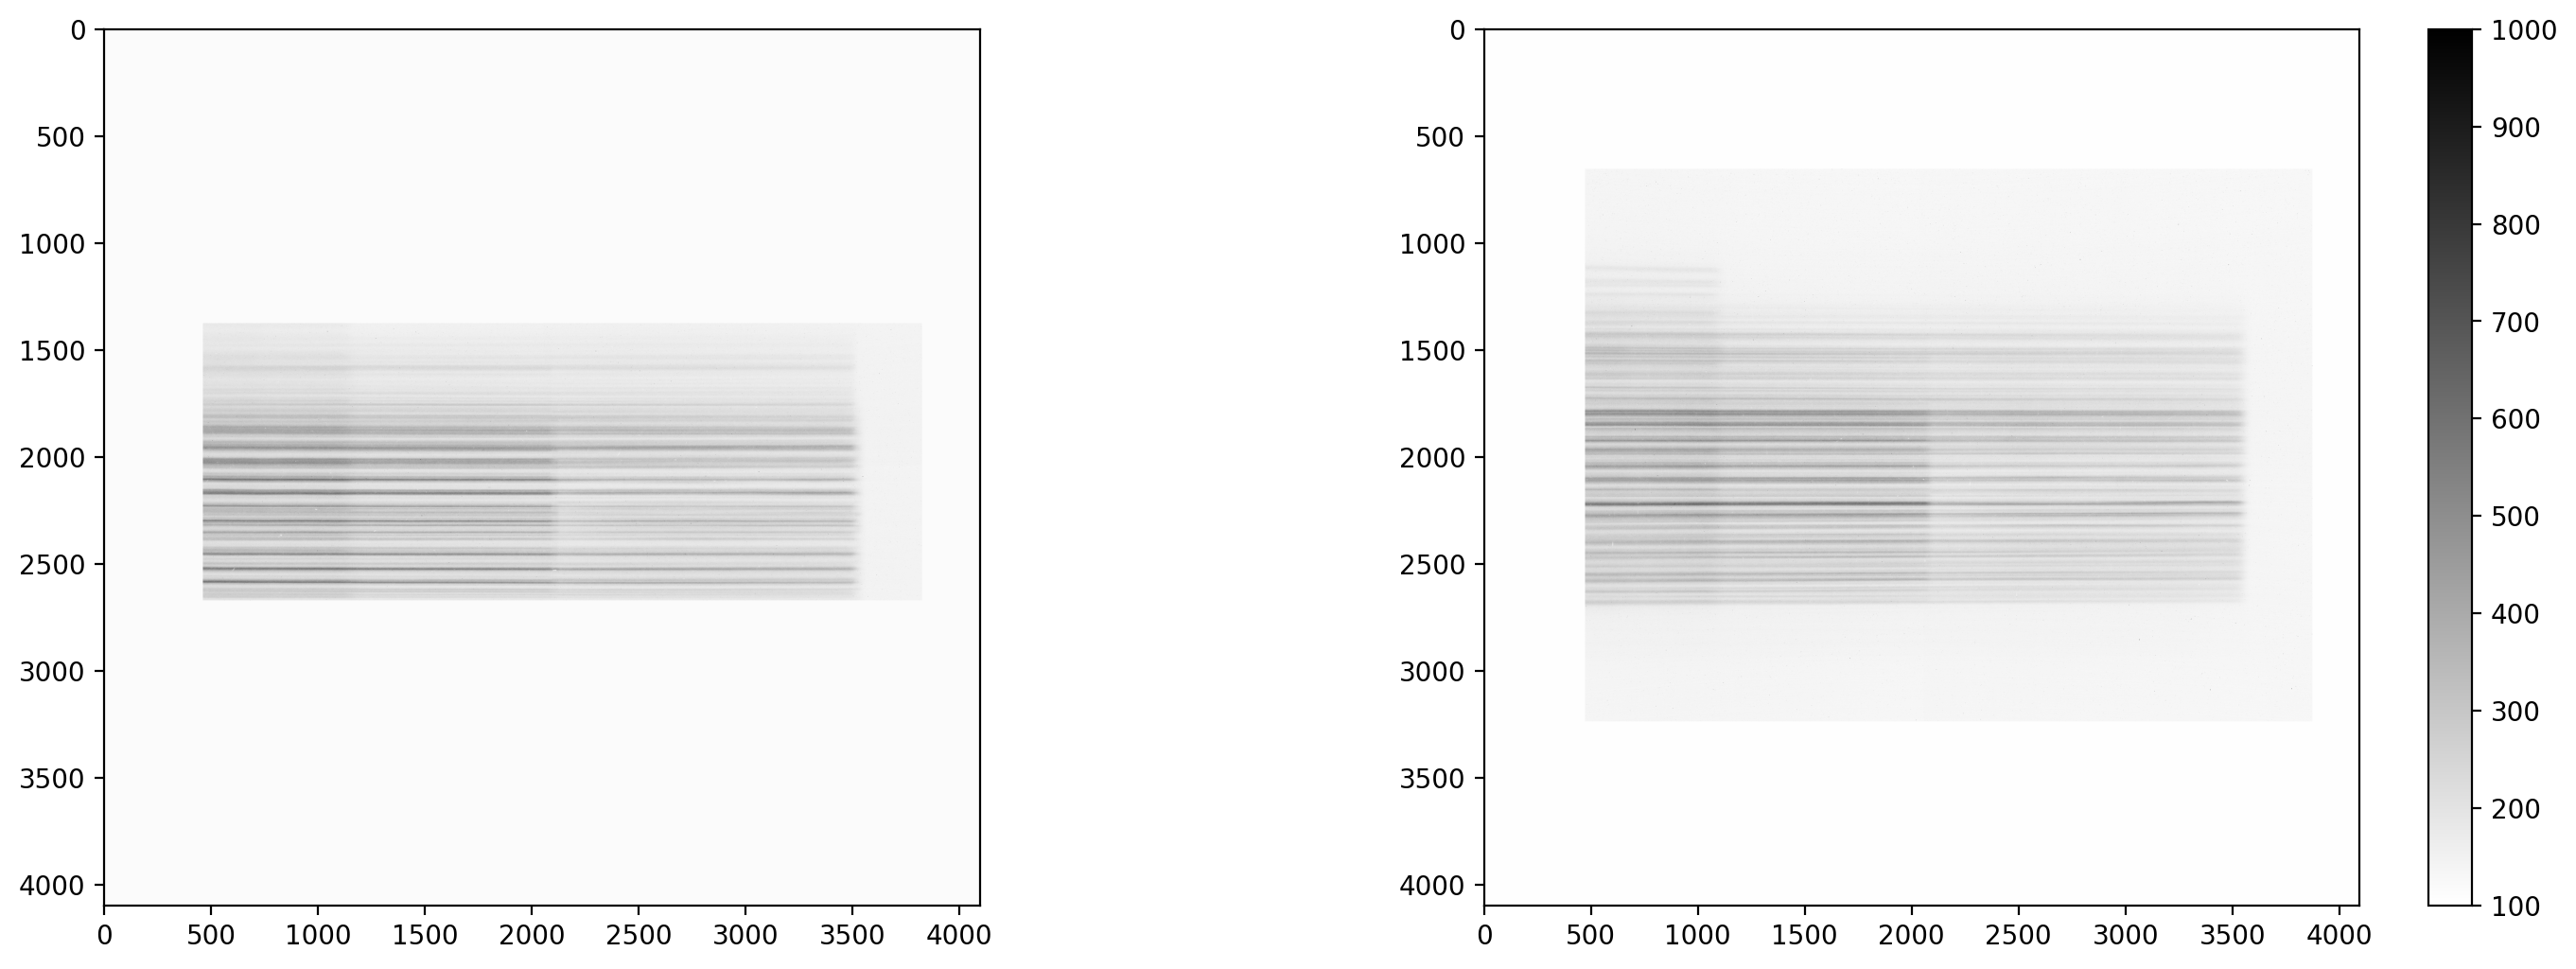

In [5]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(imgKEP1_r, vmin = 100, vmax = 1000, cmap = plt.cm.binary)

plt.subplot(222)
plt.imshow(imgKEP2_r, vmin = 100, vmax = 1000, cmap = plt.cm.binary)
# plt.hlines(3000, 0, 4095, color = 'w')
# plt.hlines(3200, 0, 4095, color = 'w')
plt.colorbar()
plt.tight_layout()
plt.show()

In [6]:
def erfFunction_left(t, A, C, t0, sigma):
    return A*(0.5+0.5*special.erf((t-t0)/sigma))+C


def erfFunction_right(t, A, C, t0, sigma):
    return A*(0.5-0.5*special.erf((t-t0)/sigma))+C

In [7]:
lineout_KEPLER1 = np.mean(imgKEP1_r[2000:2500, 1500:2300], axis = 0)
popt_KEPLER1, pcov = curve_fit(erfFunction_left, xdata=np.arange(0, lineout_KEPLER1.shape[0], 1), ydata=lineout_KEPLER1, p0 = [1., 200, 600., 20.], maxfev = 3000)
print(popt_KEPLER1)
lineout_KEPLER2 = np.mean(imgKEP2_r[2000:2500, 1500:2300], axis = 0)
popt_KEPLER2, pcov = curve_fit(erfFunction_left, xdata=np.arange(0, lineout_KEPLER2.shape[0], 1), ydata=lineout_KEPLER2, p0 = [1., 250, 600., 20.], maxfev = 3000)
print(popt_KEPLER2)

[ 51.02366734 240.51564532 602.78201656 -25.88321499]
[-56.03890916 284.90956213 575.21317578  22.54212264]


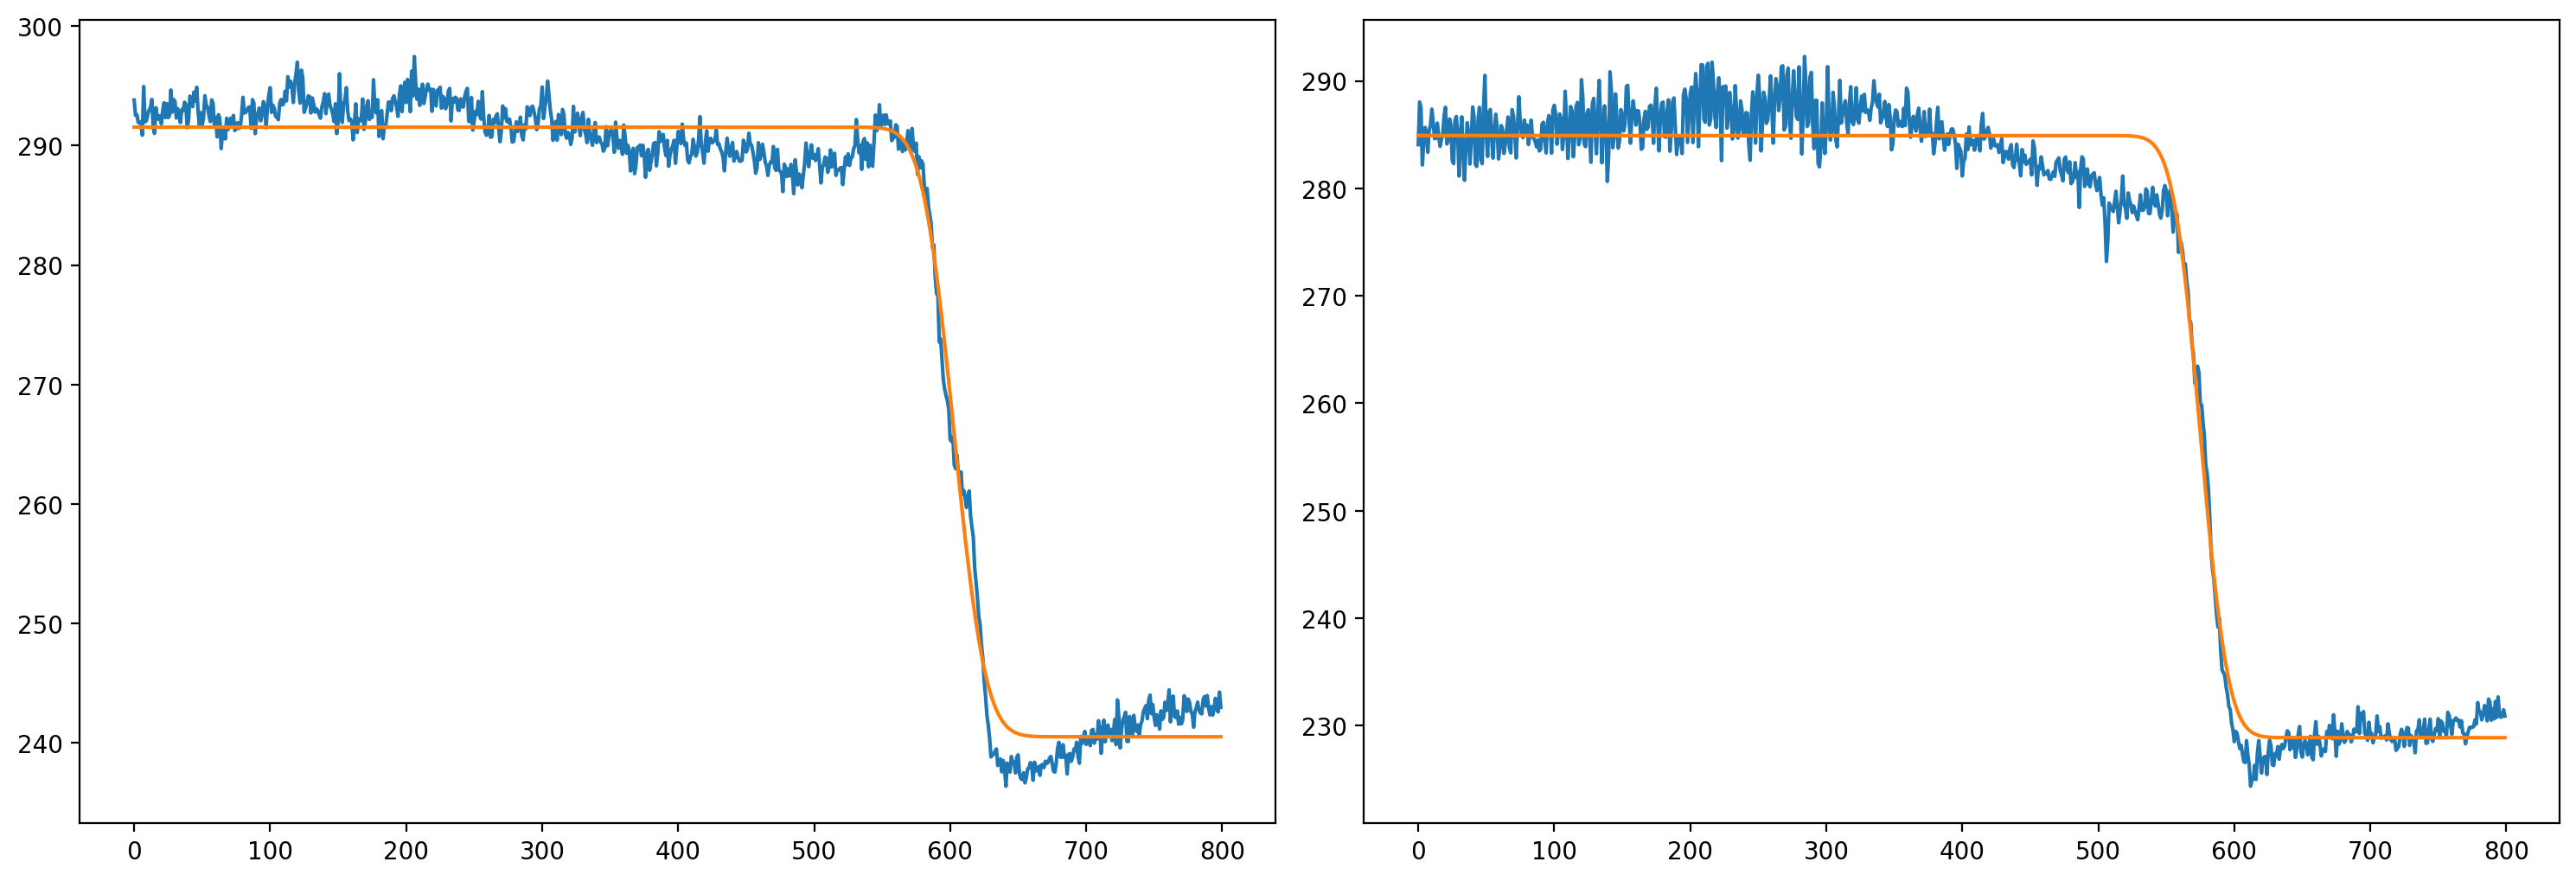

In [8]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.plot(lineout_KEPLER1)
x = np.arange(0, lineout_KEPLER1.shape[0], 1)
plt.plot(x, erfFunction_left(x, *popt_KEPLER1))

plt.subplot(222)
plt.plot(lineout_KEPLER2)
x = np.arange(0, lineout_KEPLER2.shape[0], 1)
plt.plot(x, erfFunction_left(x, *popt_KEPLER2))
# plt.hlines(3000, 0, 4095, color = 'w')s
# plt.hlines(3200, 0, 4095, color = 'w')

plt.tight_layout()
plt.show()

In [9]:
print(1500+popt_KEPLER1[2], 1500+popt_KEPLER2[2])

2102.7820165577627 2075.213175777053


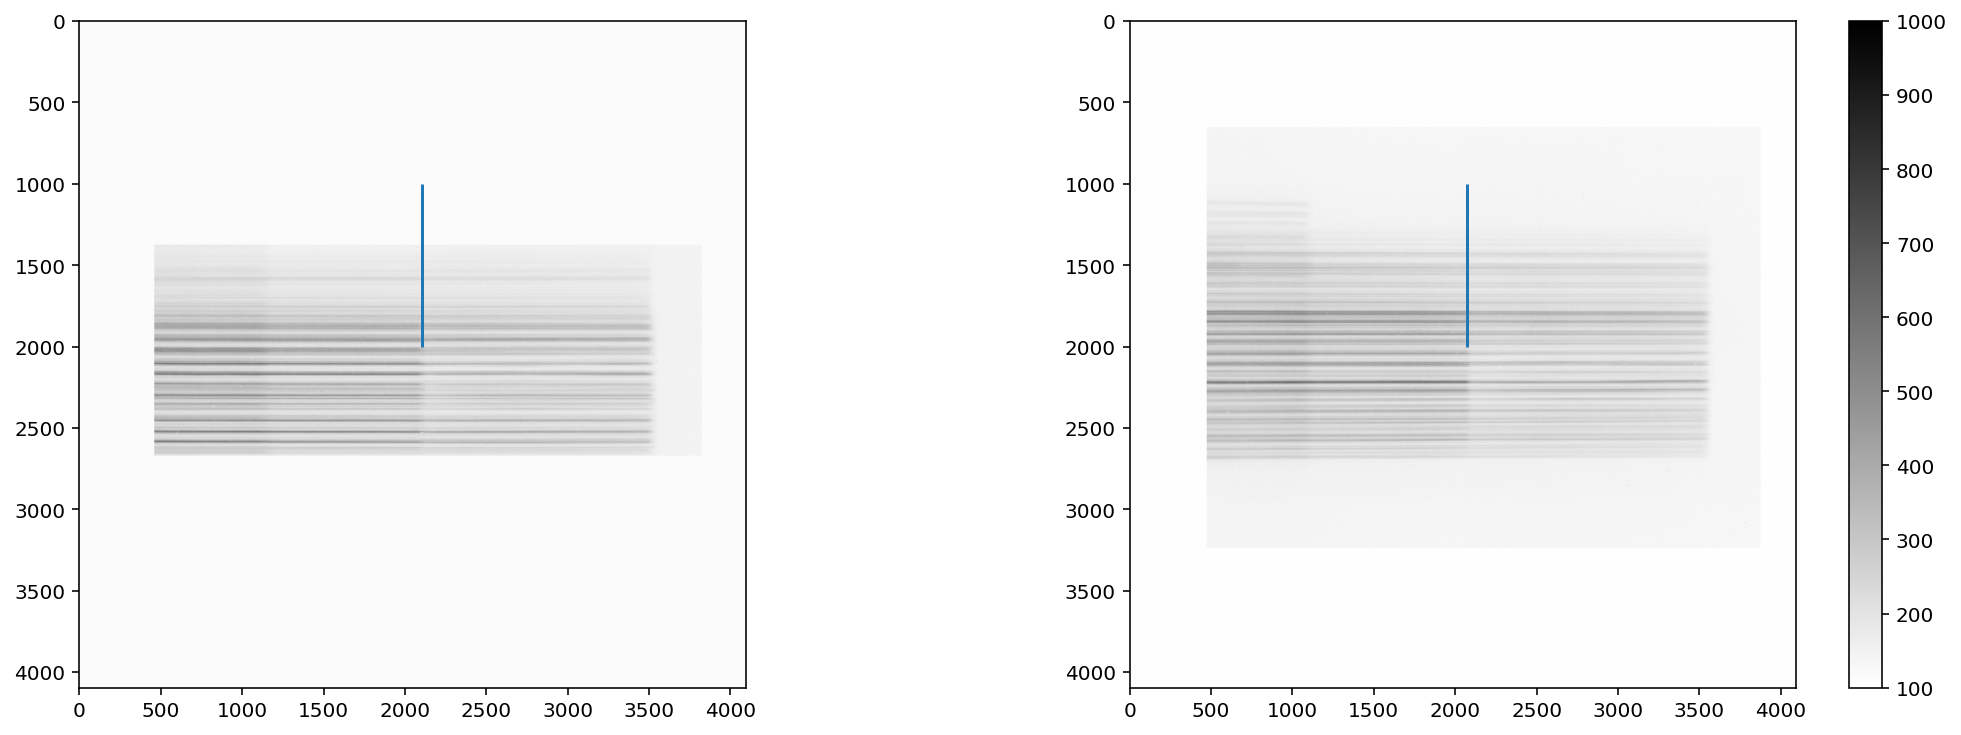

In [41]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(imgKEP1_r, vmin = 100, vmax = 1000, cmap = plt.cm.binary)
plt.vlines(1500+popt_KEPLER1[2], 1000, 2000)

plt.subplot(222)
plt.imshow(imgKEP2_r, vmin = 100, vmax = 1000, cmap = plt.cm.binary)
plt.vlines(1500+popt_KEPLER2[2], 1000, 2000)
# plt.hlines(3000, 0, 4095, color = 'w')
# plt.hlines(3200, 0, 4095, color = 'w')
plt.colorbar()
plt.tight_layout()
plt.show()